In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PyMooOpt import CSROptProblem, lmd, NGauss, beam_charge,sigma_z,energy,R,phi,sigmax,NGauss,Nwake, evolve_distribution
from PyMooOpt import gauss_deriv, gauss_sum, run_opt_scaling
from pymoo.decomposition.asf import ASF
import matplotlib.pylab as pylab
import time

sigma = sigma_z
xGauss = np.linspace(-3*sigma,3*sigma,NGauss)
z = np.linspace(-5*sigma,5*sigma,Nwake)

weights = np.array([0.9, 0.1])
decomp = ASF()
FONTSIZE = 18
params = {'legend.fontsize': FONTSIZE-4,
          'figure.figsize': (12, 8),
         'axes.labelsize': FONTSIZE,
         'axes.titlesize': FONTSIZE+8,
         'xtick.labelsize': FONTSIZE-2,
         'ytick.labelsize': FONTSIZE,}

pylab.rcParams.update(params)

In [3]:
NGauss

32

In [4]:
import re
import pickle
from pathlib import Path
from typing import Iterable

def get_profiles(filepath, append_energy:bool = False):

    files = list(Path(filepath).glob('*.pkl'))
    profile_entries = []

    for file in files:
        with open(file, 'rb') as f:
            obj = pickle.load(f)

            #evil regex to extract energy value
            match = re.search(r'_([0-9]+(?:\.[0-9]+)?)_MeV', str(file))
            if match:
                value = float(match.group(1))
                profile_entries.append((value, obj))

    # Sort by the numeric value
    profile_entries.sort(key=lambda x: x[0])

    # Separate the sorted profiles and names
    profiles = [entry[1] for entry in profile_entries]

    if append_energy:
        profilenames = [f"{entry[0]}MeV" for entry in profile_entries]
    else:
        profilenames = [entry[0] for entry in profile_entries]

    return profiles, profilenames


def plot_profiles(filepath:str, title:str, wantedEnergies:Iterable[str] | None = None) -> None:
    profiles, profilenames = get_profiles(filepath=filepath)
    print(f"Available Energies: {profilenames}")

    for i, profile in enumerate(profiles):
        if wantedEnergies is None or any(profilenames[i] == energy for energy in wantedEnergies):
            Lmd_noShld_rel_sig7 = lmd(np.linspace(-5*sigma,5*sigma,1001),xGauss,profile.X,sigmax*np.ones(NGauss)*0.95,deriv=False)
            plt.plot(np.linspace(-5*sigma,5*sigma,1001),Lmd_noShld_rel_sig7, label=profilenames[i])

    plt.title(title)
    plt.xlabel(r"$z$ (m)")
    plt.ylabel(r"$E_z$ (KeV)")
    plt.grid()
    plt.plot()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('noshld.png')


def get_cost_functions(filepath:str, wantedEnergies:Iterable[str] | None = None) -> list[float]:
    profiles, profilenames = get_profiles(filepath=filepath, append_energy=False)
    cost_functions = []
    print(f"Available Energies: {profilenames}")
    for i, profile in enumerate(profiles):
        if wantedEnergies is None or any(profilenames[i] == energy for energy in wantedEnergies):
            cost_functions.append((profilenames[i], profile.F[0]))

    return cost_functions

import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_convergence(filepath: str, wantedenergies: list[str] | None = None) -> None:
    profiles, profilenames = get_profiles(filepath=filepath, append_energy=False)
    print(f"available energies: {profilenames}")

    energies = [float(energy) for energy in profilenames]

    norm = mcolors.Normalize(vmin=np.min(energies), vmax=np.max(energies))
    cmap = cm.get_cmap('coolwarm')

    for i, profile in enumerate(profiles):
        energy = energies[i]
        if wantedenergies is None or any(profilenames[i] == energy for energy in wantedenergies):
            n_evals = np.array([e.evaluator.n_eval for e in profile.history])
            opt = np.array([e.opt[0].f for e in profile.history])

            # Get color from colormap based on energy
            color = cmap(norm(energy))
            plt.plot(n_evals, opt, "-", color=color, label=f"{energy:.1f} MeV")

    plt.title("Convergence (2cm shielding gap)")
    plt.grid()
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="Energy (MeV)", ax=plt.gca())
    plt.xlabel("Evaluations")
    plt.ylabel("Objective Value")
    plt.show()

# Sensitivity Analysis

Available Energies: [30.0, 30.01, 31.0, 31.01, 32.0, 32.01, 33.0, 33.01, 34.0, 34.01, 35.0, 35.01, 36.0, 36.01, 37.0, 37.01, 38.0, 38.01, 39.0, 39.01, 40.0, 40.01, 41.0, 41.01, 42.0, 42.01, 43.0, 43.01, 44.0, 44.01, 45.0, 45.01, 46.0, 46.01, 47.0, 47.01, 48.0, 48.01, 49.0, 49.01, 50.0, 50.01]


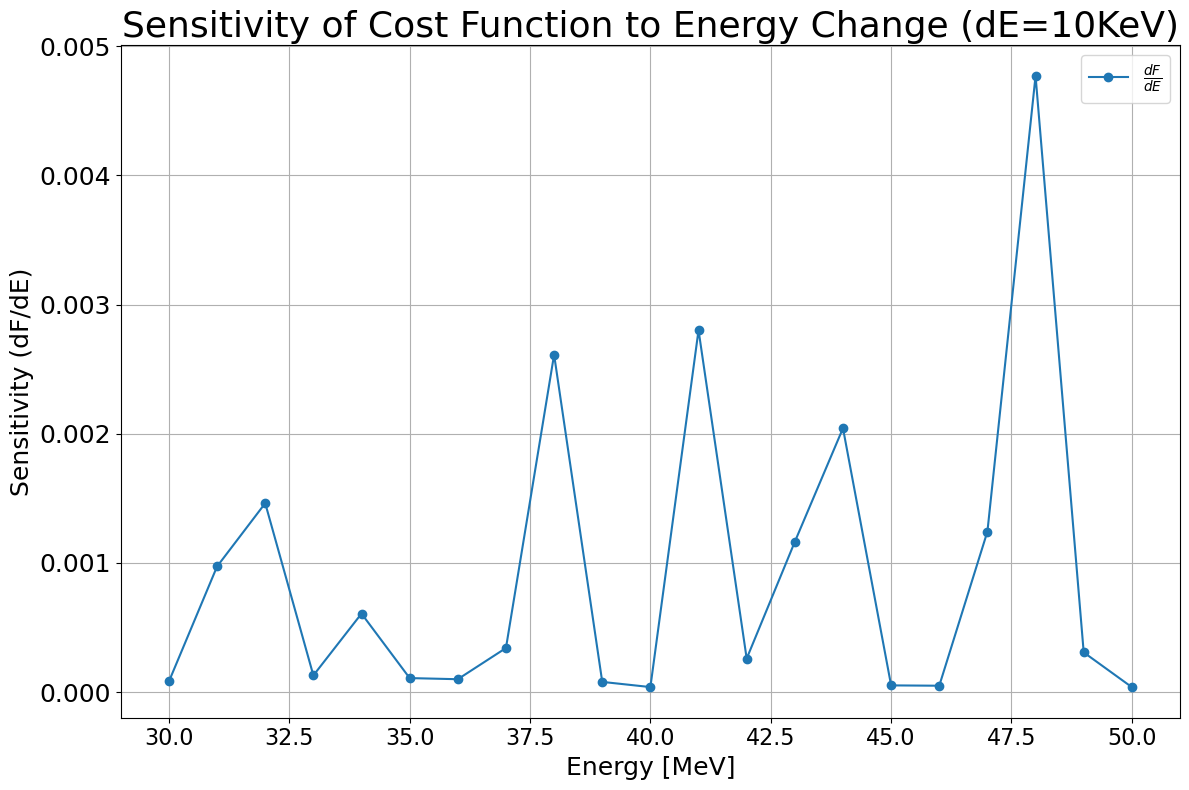

In [5]:
cf = get_cost_functions("sens_analysis/4cm_shld/")

energies = []
sensitivities = []

# now, the sensitivity is simply dF/dE which I calculate here
for i in range(len(cf)):
    if i % 2 == 0:
        dE = abs(cf[i][0] - cf[i+1][0])
        dF = cf[i][1] - cf[i+1][1]
        sensitivity = dF / dE

        energies.append(cf[i][0])
        sensitivities.append(sensitivity)

# Plotting
plt.plot(energies, np.abs(sensitivities), 'o-', color='tab:blue', label=r'$\frac{dF}{dE}$')

plt.xlabel('Energy [MeV]')
plt.ylabel('Sensitivity (dF/dE)')
plt.title('Sensitivity of Cost Function to Energy Change (dE=10KeV)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Convergence Analysis

available energies: [30.0, 30.01, 31.0, 31.01, 32.0, 32.01, 33.0, 33.01, 34.0, 34.01, 35.0, 35.01, 36.0, 36.01, 37.0, 37.01, 38.0, 38.01, 39.0, 39.01, 40.0, 40.01, 41.0, 41.01, 42.0, 42.01, 43.0, 43.01, 44.0, 44.01, 45.0, 45.01, 46.0, 46.01, 47.0, 47.01, 48.0, 48.01, 49.0, 49.01, 50.0, 50.01]


/tmp/ipykernel_24854/1312600043.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


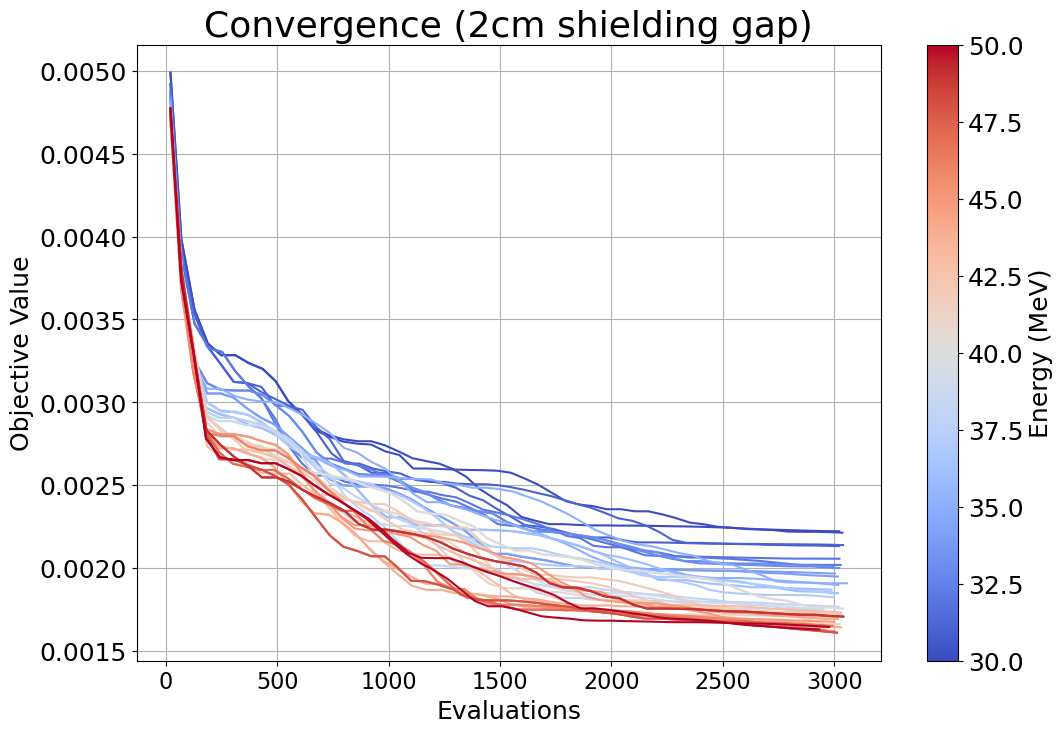

In [6]:
# i wonder if i can get the history from the pkl's
plot_convergence("sens_analysis/2cm_shld/")

Available Energies: [30.0, 30.5, 32.0, 32.5, 34.0, 34.5, 36.0, 36.5, 38.0, 38.5, 40.0, 40.5, 42.0, 42.5, 44.0, 44.5, 46.0, 46.5, 48.0, 48.5, 50.0, 50.5, 144.0, 144.5, 416.0, 416.5, 652.0, 652.5, 814.0, 814.5, 1201.0, 1201.5, 1606.0, 1606.5, 2521.0, 2521.5, 3465.0, 3465.5, 10000.0, 10000.5]


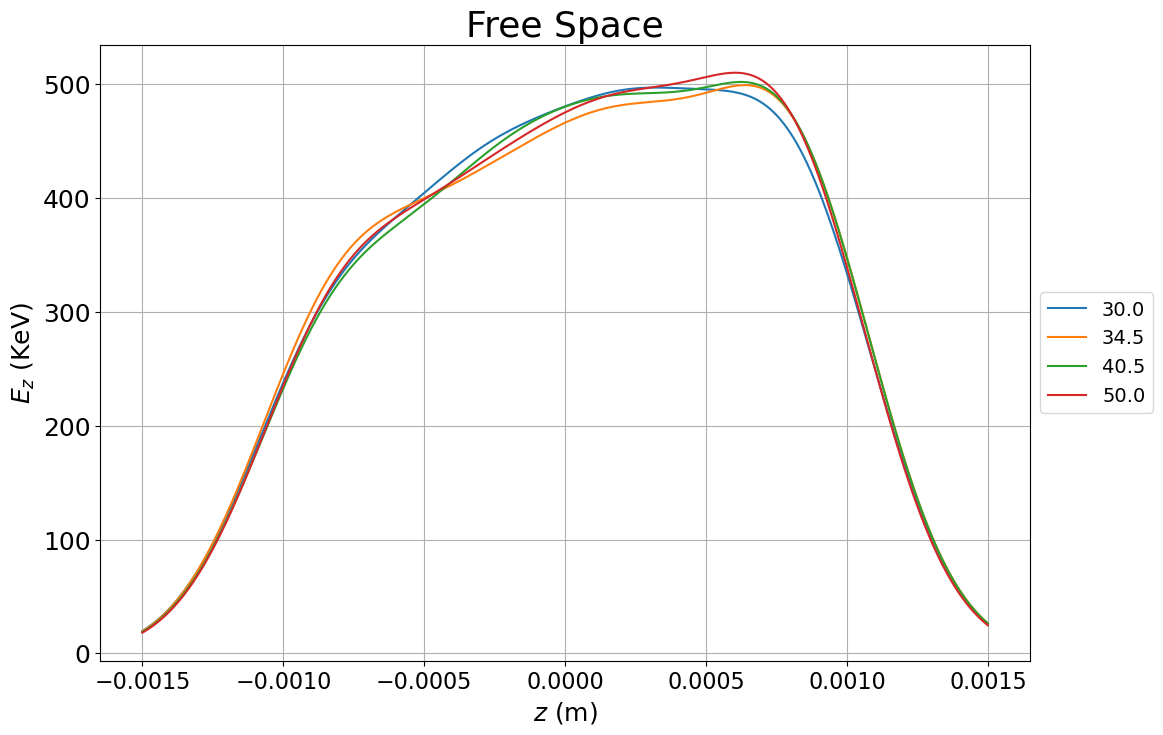

In [7]:
# ************
#  Free Space
# ************
# wantedEnergies = ["30MeV", "50MeV", "652MeV", "1606MeV", "3465MeV", "10000MeV"]

wantedEnergies=[30, 34.5, 40.5, 50]
plot_profiles("free_space/", title="Free Space", wantedEnergies=wantedEnergies)

In [8]:
loEnergies = np.linspace(start = 30, stop = 50, num = 10, endpoint=False)
midEnergies = np.array([652, 814, 1606, 2521])
hiEnergies = np.geomspace(start = 50, stop = 10000, num = 6)
energyArray = np.concatenate([loEnergies, midEnergies, hiEnergies], axis=None)

energyArray

array([   30.        ,    32.        ,    34.        ,    36.        ,
          38.        ,    40.        ,    42.        ,    44.        ,
          46.        ,    48.        ,   652.        ,   814.        ,
        1606.        ,  2521.        ,    50.        ,   144.26999059,
         416.2766037 ,  1201.12443398,  3465.72421578, 10000.        ])

Available Energies: [30.0, 30.5, 32.0, 32.5, 34.0, 34.5, 36.0, 36.5, 38.0, 38.5, 40.0, 40.5, 42.0, 42.5, 44.0, 44.5, 46.0, 46.5, 48.0, 48.5, 50.0, 50.5, 144.26999059072133, 144.76999059072133, 416.27660370093656, 416.77660370093656, 652.0, 652.5, 814.0, 814.5, 1201.1244339814311, 1201.6244339814311, 1606.0, 1606.5, 2521.0, 2521.5, 3465.724215775732, 10000.0]


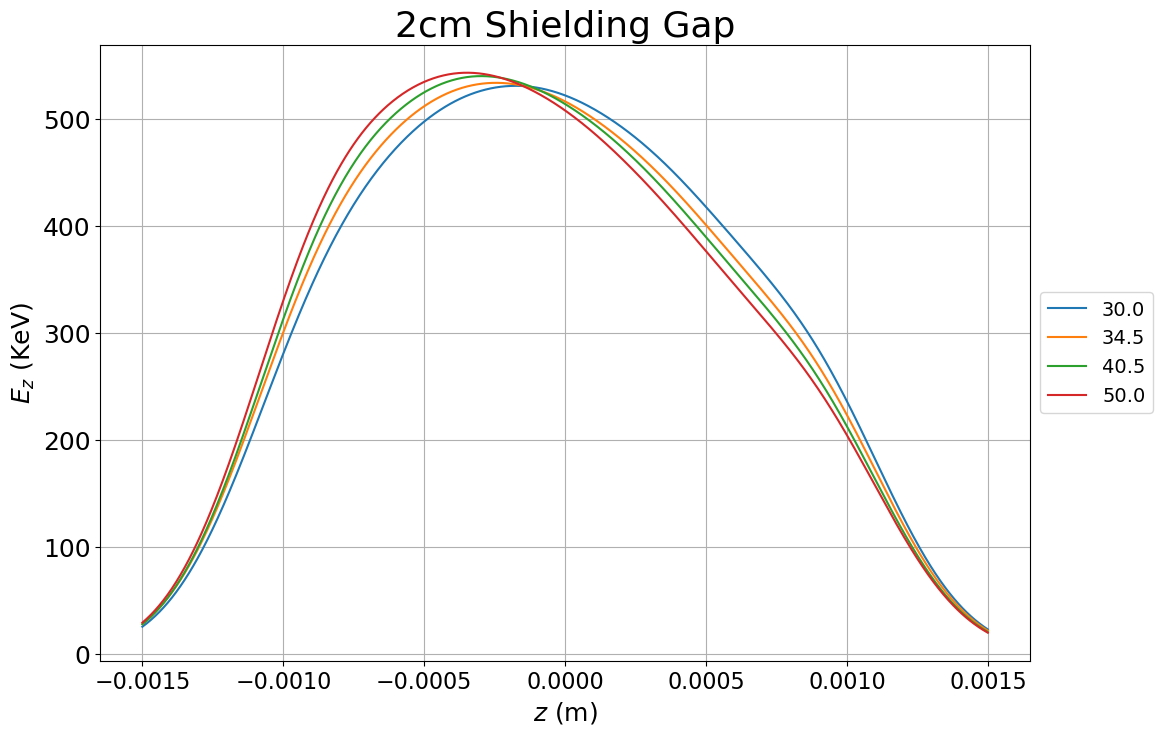

In [14]:
# ************
#  2cm Shield
# ************
wantedEnergies=[30, 34.5, 40.5, 50]
plot_profiles("2cm_shld/", title="2cm Shielding Gap", wantedEnergies=wantedEnergies)

Available Energies: [30.0, 30.5, 32.0, 32.5, 34.0, 34.5, 36.0, 36.5, 38.0, 38.5, 40.0, 40.5, 42.0, 42.5, 44.0, 44.5, 46.0, 46.5, 48.0, 48.5, 50.0, 50.5, 144.26999059072133, 144.76999059072133, 416.27660370093656, 416.77660370093656, 652.0, 652.5, 814.0, 814.5, 1201.1244339814311, 1201.6244339814311, 1606.0, 1606.5, 2521.0, 2521.5, 3465.724215775732, 3466.224215775732, 10000.0, 10000.5]


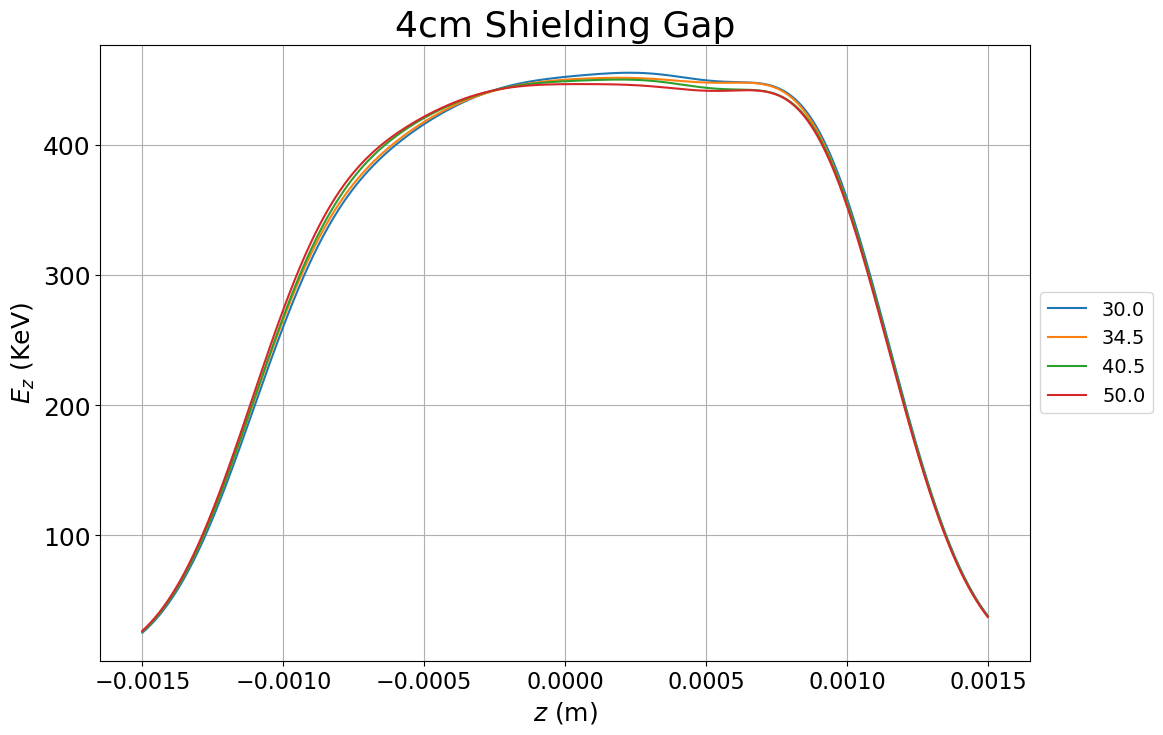

In [10]:
# ************
#  4cm Shield
# ************
wantedEnergies=[30, 34.5, 40.5, 50]
plot_profiles("4cm_shld/", title="4cm Shielding Gap", wantedEnergies=wantedEnergies)

In [11]:
sigmax

0.0003

## Convergence Analysis

In [12]:
# get the cost function of each profile
prof_shld_2cm, name_shld_2cm = get_profiles("2cm_shld/")
prof_shld_4cm, name_shld_4cm = get_profiles("4cm_shld/")
prof_freespace, name_freespace = get_profiles("free_space/")

In [13]:
plotcolor = 'red'
# Lmd_noShld_rel_sig7 = lmd(np.linspace(-5*sigma,5*sigma,1001),xGauss,NoShld_ur.X,sigmax/1.5*np.ones(NGauss),deriv=False)
#Lmd_noShld2 = lmd(z,[sigma,1.0,1.0],xGauss,NoShld.X[-1][:-1],sigmax/NoShld.X[0,-1]*np.ones(NGauss),deri7=False)
#Lmd_noShld3 = lmd(z,[sigma,1.0,1.0],xGauss,NoShld.X[3][:-1],sigmax/NoShld.X[3,-1]*np.ones(NGauss),deriv=False)
#energies_noShld_rel = evolve_distribution(1e-2,z,beam_charge,Nwake,0,R,phi,energy,xGauss,NoShld.X,sigmax*np.ones(NGauss)/4)
#energies_noShld2 = evolve_distribution(1e-2,z,beam_charge,Nwake,0,R,phi,energy,xGauss,NoShld.X[-1][:-1],sigmax*np.ones(NGauss)/NoShld.X[0,-1])
#energies_noShld3 = evolve_distribution(1e-2,z,beam_charge,Nwake,0,R,phi,energy,xGauss,NoShld.X[3][:-1],sigmax*np.ones(NGauss)/NoShld.X[3,-1])
#plt.stairs(Lmd_noShld_rel[1:]/5,z/sigma,color=plotcolor,fill=True,alpha=0.2)

# plt.plot(np.linspace(-5*sigma,5*sigma,1001),Lmd_noShld_rel_sig7)

#plt.plot((z[1:]+z[:-1])/2/sigma,energies_noShld_rel*1e3,color=plotcolor)
#plt.stairs(Lmd_noShld2[1:]/5,z/sigma,color='blue',fill=True,alpha=0.2)
#plt.plot((z[1:]+z[:-1])/2/sigma,energies_noShld2*1e3,color='blue')
#plt.stairs(Lmd_noShld3[1:]/5,z/sigma,color='black',fill=True,alpha=0.2)
#plt.plot((z[1:]+z[:-1])/2/sigma,energies_noShld3*1e3,color='black')

for i, profile in enumerate(profiles):
    #if i != 4 and i != 5 and i !=6:
    #   continue

    Lmd_noShld_rel_sig7 = lmd(np.linspace(-5*sigma,5*sigma,1001),xGauss,profile.X,sigmax*np.ones(NGauss)*0.95,deriv=False)
    plt.plot(np.linspace(-5*sigma,5*sigma,1001),Lmd_noShld_rel_sig7, label=profilenames[i])

# Lmd_noShld_rel_sig7 = lmd(np.linspace(-5*sigma,5*sigma,1001),xGauss,test.X,sigmax*np.ones(NGauss)*1.,deriv=False)
# plt.plot(np.linspace(-5*sigma,5*sigma,1001),Lmd_noShld_rel_sig7, label='test')

plt.xlabel(r"$s/\sigma$")
plt.ylabel(r"$\delta E_{s}$ (KeV)")
plt.grid()
# plt.legend()
plt.title("No Shielding")
plt.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('noshld.png')

NameError: name 'profiles' is not defined

In [ ]:
run_opt_scaling(['scaling_40_gens.txt',40,24,24,5])

In [ ]:
cores = np.linspace(1,24,24)
x = np.loadtxt('scaling_20_gens.txt')
y = np.loadtxt('scaling/20gen_metis.out')
z = np.loadtxt('scaling/20gen_nersc.out')
plt.errorbar(cores,x[:,1],yerr=x[:,2],capsize=2.0,color='black')
plt.plot(cores,x[:,1],'.',color='black',label="My Work Machine")
cores2 = y[:,0]
plt.errorbar(cores2,y[:,1],yerr=y[:,2],capsize=2.0,color='red')
plt.plot(cores2,y[:,1],'.',color='red',label="METIS")
cores3 = z[:,0]
plt.errorbar(cores3,z[:,1],yerr=z[:,2],capsize=2.0,color='blue')
plt.plot(cores3,z[:,1],'.',color='blue',label="NERSC")
plt.grid()
plt.xlabel(r"Number of Cores")
plt.ylabel(r"Runtime (s)")

In [ ]:
cores = np.linspace(1,24,24)
x = np.loadtxt('scaling_40_gens.txt')
y = np.loadtxt('scaling/40gen_metis.out')
z = np.loadtxt('scaling/40gen_nersc.out')
plt.semilogy(cores,x[:,1],color='black')
plt.plot(cores,x[:,1],'.',color='black',label="My Work Machine")
cores2 = y[:,0]
plt.semilogy(cores2,y[:,1],color='red')
plt.plot(cores2,y[:,1],'.',color='red',label="METIS")
cores3 = z[:,0]
plt.semilogy(cores3,z[:,1],color='blue')
plt.plot(cores3,z[:,1],'.',color='blue',label="METIS")
plt.grid()
plt.xlabel(r"Number of Cores")
plt.ylabel(r"Runtime (s)")

In [ ]:
np.sum(z[4:,1]/z[4,1]*55/60)*5

In [ ]:
45.72185320854187/40.99452352523804

In [ ]:
z[5,1]/z[6,1]

In [ ]:
gen40 = np.loadtxt("scaling/40gen_nersc.out")
gen100 = np.loadtxt("scaling/100gen_nersc.out")

plt.plot(gen40[:,0],gen40[:,1]*np.mean(gen100[:,1]/gen40[:,1]),'r')
plt.plot(gen100[:,0],gen100[:,1],color='black')

In [ ]:
np.mean(gen100[:,1]/gen40[:,1])

In [ ]:
np.std(gen100[:,1]/gen40[:,1])

In [ ]:
diff = [arr[i]/arr[0] for i in range(len(arr))]

In [ ]:
len(arr)

In [ ]:
sum(z[len(arr):,1]*220.19457993507385/91.48176227)/60*5

In [ ]:
#### z[:len(arr),1]
diffz = [z[i,1]/z[0,1] for i in range(len(arr))]

print(diffz)

In [ ]:
N = -1
np.sum(z[len(arr):N,1]/z[0,1]*220.19457993507385)/60*5

In [ ]:
64-17

In [ ]:
plt.semilogy(z[:len(arr),1],'r')
plt.semilogy(z[:len(arr),1],'r.')
plt.semilogy(arr/arr[0]*z[0,1],color='black')
plt.semilogy(arr/arr[0]*z[0,1],'.',color='black')

In [ ]:
101/6

In [ ]:
Ntimes = 24
Nsamps = 5
Nthreads = np.linspace(1,24,Ntimes,dtype=int)
times_vs_threads40 = np.zeros([Ntimes,2])

for i in range(Ntimes):
    curtime = np.zeros(Nsamps)
    for j in range(Nsamps):
        start = time.time()
        run_opt_problem([Nthreads[i],20,"test.out"])
        #evolve_distribution(2e-2,z,beam_charge,Nwake,Nimages[i],R,phi,energy,xGauss,NoShld_ur.X,sigmax*np.ones(NGauss)/2)
        end = time.time()
        curtime[j] = end-start
    print(Nthreads[i], np.mean(curtime), np.std(curtime))
    times_vs_threads40[i] = np.array([np.mean(curtime),np.std(curtime)])

In [ ]:
Nthreads

In [ ]:
Ntimes = 10
Nsamps = 5
Nimages = np.linspace(0,32,Ntimes,dtype=int)
times = np.zeros([Ntimes,2])

for i in range(Ntimes):
    curtime = np.zeros(Nsamps)
    for j in range(Nsamps):
        start = time.time()
        energies_noShld_rel = evolve_distribution(2e-2,z,beam_charge,Nwake,Nimages[i],R,phi,energy,xGauss,NoShld_ur.X,sigmax*np.ones(NGauss)/2)
        end = time.time()
        curtime[j] = end-start
    print(Nimages[i], np.mean(curtime), np.std(curtime))
    times[i] = np.array([np.mean(curtime),np.std(curtime)])

In [ ]:
gauss_deriv(0,NGauss,xGauss,NoShld_ur.X,sigmax*np.ones(NGauss)/2)

In [ ]:
#times = np.loadtxt("times_bad_deriv.txt")
plt.errorbar(Nthreads,times_vs_threads40[:,0],yerr=times_vs_threads40[:,1],color='red',capsize=3.0)
plt.plot(Nthreads,times_vs_threads40[:,0],'.',color='red',label="40 Generations")
#plt.errorbar(Nimages[1:],times2[1:,0],yerr=times2[1:,1],color='black',capsize=3.0)
#plt.plot(Nimages[1:],times2[1:,0],'.',color='black',label="Better Gauss Derivative")
plt.legend()
plt.grid()
plt.xlabel(r"Nimages")
plt.ylabel(r"Serial Runtime (s)")
plt.savefig("20gen_noshld_scaling.png")

In [ ]:
plt.errorbar(Nimages,times[:,0],yerr=times[:,1],color='black',capsize=3.0)
plt.plot(Nimages,times[:,0],'.',color='black')
plt.grid()

In [ ]:
def ultra_rel(z,length):
    res = np.zeros(len(z))
    ii = np.where(abs(z) < length/2)
    jj = np.where(abs(z) >= length/2)
    res[ii] = (z[ii]+length/2)**(1/3)/(length)**(4/3)
    res[jj] = 0
    return res

zp = np.linspace(-4*sigma,4*sigma,101)
#plt.plot(z,Lmd_noShld,color='blue')
# plt.plot(zp/1e-3,lmd(zp,[sigma,1.0,1.0],xGauss,profiles[-1].X,sigmax/7*np.ones(NGauss),deriv=False),color='red',label="This Work")
for i, profile in enumerate(profiles):
    plt.plot(zp/1e-3,lmd(zp,xGauss,profile.X,sigmax*np.ones(NGauss),deriv=False), label=profilenames[i])


plt.plot(zp/1e-3,4/3*ultra_rel(zp,5.6*sigma),'-.',color='black',label="Analytical")
plt.grid()
plt.xlabel(r"$z$ (mm)")
plt.legend()
plt.savefig('64Gauss_w_Filter.png')
#plt.ylabel(r"$$")

In [ ]:
print(phi)
energies_40mev = evolve_distribution(5e-2,z,beam_charge,Nwake,0,R,phi,energy,xGauss,np.array(NoShld_ur.X),sigmax*np.ones(NGauss))
energies_40mev_flat = evolve_distribution(5e-2,z,beam_charge,Nwake,0,R,phi,energy,xGauss,np.ones(len(NoShld_ur.X)),sigmax*np.ones(NGauss))

plt.plot((zp[1:]+zp[:-1])/2e3, energies_40mev)
plt.plot((zp[1:]+zp[:-1])/2e3, energies_40mev_flat)

In [ ]:
np.linalg.norm(lmd(zp,[sigma,1.0,1.0],xGauss,NoShld_ur.X,sigmax/5*np.ones(NGauss),deriv=False)-4/3*ultra_rel(zp,5.6*sigma))/np.linalg.norm(4/3*ultra_rel(zp,5.6*sigma))

In [ ]:
3*sigma

In [ ]:
NoShld.X

In [ ]:
# 5cm Shielding
with open("1drun_04_04_2025/weights_5cm_3images.out", 'rb') as file:
    W5cm = pickle.load(file)

plotcolor = 'red'
Lmd_5cm = lmd(z,[sigma,1.0,1.0],xGauss,W5cm.X,sigmax*np.ones(NGauss),deriv=False)
energies_5cm = evolve_distribution(5e-2,z,beam_charge,Nwake,3,R,phi,energy,xGauss,W5cm.X,sigmax*np.ones(NGauss))
energies_5cm_noShld = evolve_distribution(5e-2,z,beam_charge,Nwake,3,R,phi,energy,xGauss,NoShld.X,sigmax*np.ones(NGauss))
plt.stairs(Lmd_noShld[1:]/5,z/sigma,color='blue',fill=True,alpha=0.2)
plt.plot((z[1:]+z[:-1])/2/sigma,energies_5cm_noShld*1e3,color='blue',label="Mitchell et al.")
plt.stairs(Lmd_5cm[1:]/5,z/sigma,color=plotcolor,fill=True,alpha=0.2)
plt.plot((z[1:]+z[:-1])/2/sigma,energies_5cm*1e3,color=plotcolor,label="This Work")
plt.xlabel(r"$s/\sigma$")
plt.ylabel(r"$\delta E_{s}$ (KeV)")
plt.grid()
plt.legend()
plt.title("Gap Size: 5cm")
plt.savefig('5cm.png')

In [ ]:
# 4cm Shielding
with open("1drun_04_04_2025/weights_4cm_4images.out", 'rb') as file:
    W4cm = pickle.load(file)

plotcolor='red'
Lmd_4cm = lmd(z,[sigma,1.0,1.0],xGauss,W4cm.X,sigmax*np.ones(NGauss),deriv=False)
energies_4cm = evolve_distribution(4e-2,z,beam_charge,Nwake,4,R,phi,energy,xGauss,W4cm.X,sigmax*np.ones(NGauss))
energies_4cm_noShld = evolve_distribution(4e-2,z,beam_charge,Nwake,4,R,phi,energy,xGauss,NoShld.X,sigmax*np.ones(NGauss))
plt.stairs(Lmd_noShld[1:]/5,z/sigma,color='blue',fill=True,alpha=0.2)
plt.plot((z[1:]+z[:-1])/2/sigma,energies_4cm_noShld*1e3,color='blue',label="Mitchell et al.")
plt.stairs(Lmd_4cm[1:]/5,z/sigma,color=plotcolor,fill=True,alpha=0.2)
plt.plot((z[1:]+z[:-1])/2/sigma,energies_4cm*1e3,color=plotcolor,label="This Work")
plt.xlabel(r"$s/\sigma$")
plt.ylabel(r"$\delta E_{s}$ (KeV)")
plt.grid()
plt.legend()
plt.title("Gap Size: 4cm")
plt.savefig('4cm.png')

In [ ]:
# 3cm Shielding
with open("1drun_04_04_2025/weights_3cm_5images.out", 'rb') as file:
    W3cm = pickle.load(file)

plotcolor='red'
energies_3cm_noShld = evolve_distribution(3e-2,z,beam_charge,Nwake,5,R,phi,energy,xGauss,NoShld.X,sigmax*np.ones(NGauss))
plt.stairs(Lmd_noShld[1:]/5,z/sigma,color='blue',fill=True,alpha=0.2)
plt.plot((z[1:]+z[:-1])/2/sigma,energies_3cm_noShld*1e3,color='blue',label="Mitchell et al.")
Lmd_3cm = lmd(z,[sigma,1.0,1.0],xGauss,W3cm.X,sigmax*np.ones(NGauss),deriv=False)
energies_3cm = evolve_distribution(3e-2,z,beam_charge,Nwake,5,R,phi,energy,xGauss,W3cm.X,sigmax*np.ones(NGauss))
plt.stairs(Lmd_3cm[1:]/5,z/sigma,color=plotcolor,fill=True,alpha=0.2)
plt.plot((z[1:]+z[:-1])/2/sigma,energies_3cm*1e3,color=plotcolor)
plt.xlabel(r"$s/\sigma$")
plt.ylabel(r"$\delta E_{s}$ (KeV)")
plt.grid()
plt.legend()
plt.title("Gap Size: 3cm")
plt.savefig('3cm.png')

In [ ]:
# 2cm Shielding
with open("1drun_04_04_2025/weights_2cm_8images.out", 'rb') as file:
    W2cm = pickle.load(file)

plotcolor='red'
energies_2cm_noShld = evolve_distribution(2e-2,z,beam_charge,Nwake,8,R,phi,energy,xGauss,NoShld.X,sigmax*np.ones(NGauss))
plt.stairs(Lmd_noShld[1:]/5,z/sigma,color='blue',fill=True,alpha=0.2)
plt.plot((z[1:]+z[:-1])/2/sigma,energies_2cm_noShld*1e3,color='blue',label="Mitchell et al.")
Lmd_2cm = lmd(z,[sigma,1.0,1.0],xGauss,W2cm.X,sigmax*np.ones(NGauss),deriv=False)
energies_2cm = evolve_distribution(2e-2,z,beam_charge,Nwake,8,R,phi,energy,xGauss,W2cm.X,sigmax*np.ones(NGauss))
plt.stairs(Lmd_2cm[1:]/5,z/sigma,color=plotcolor,fill=True,alpha=0.2)
plt.plot((z[1:]+z[:-1])/2/sigma,energies_2cm*1e3,color=plotcolor,label="This Work")
plt.xlabel(r"$s/\sigma$")
plt.ylabel(r"$\delta E_{s}$ (KeV)")
plt.grid()
plt.legend()
plt.title("Gap Size: 2cm")
plt.savefig('2cm.png')

In [ ]:
# 1cm Shielding
with open("1drun_04_04_2025/weights_1cm_16images.out", 'rb') as file:
    W1cm = pickle.load(file)

plotcolor='red'
Lmd_1cm = lmd(z,[sigma,1.0,1.0],xGauss,W2cm.X,sigmax*np.ones(NGauss),deriv=False)
energies_1cm = evolve_distribution(1e-2,z,beam_charge,Nwake,16,R,phi,energy,xGauss,W1cm.X,sigmax*np.ones(NGauss))
energies_1cm_noShld = evolve_distribution(1e-2,z,beam_charge,Nwake,16,R,phi,energy,xGauss,NoShld.X,sigmax*np.ones(NGauss))
plt.stairs(Lmd_noShld[1:]/5,z/sigma,color='blue',fill=True,alpha=0.2)
plt.plot((z[1:]+z[:-1])/2/sigma,energies_1cm_noShld*1e3,color='blue',label="Mitchell et al.")
plt.stairs(Lmd_1cm[1:]/5,z/sigma,color=plotcolor,fill=True,alpha=0.2)
plt.plot((z[1:]+z[:-1])/2/sigma,energies_1cm*1e3,color=plotcolor,label="This Work")
plt.xlabel(r"$s/\sigma$")
plt.ylabel(r"$\delta E_{s}$ (KeV)")
plt.grid()
plt.legend()
plt.title("Gap Size: 1 cm")
plt.savefig('1cm.png')

In [ ]:
#Lmd_1cm = lmd(z,[sigma,1.0,1.0],xGauss,W2cm.X,sigmax*np.ones(NGauss),deriv=False)
energies_1cm_noShld = evolve_distribution(1e-2,z,beam_charge,Nwake,16,R,phi,energy,xGauss,NoShld.X,sigmax*np.ones(NGauss))
plt.stairs(Lmd_noShld[1:]/5,z/sigma,color=plotcolor,fill=True,alpha=0.2)
plt.plot((z[1:]+z[:-1])/2/sigma,energies_1cm_noShld*1e3,color=plotcolor)
plt.xlabel(r"$s/\sigma$")
plt.ylabel(r"$\delta E_{s}$ (KeV)")
plt.grid()